# Imaging Quasars

In this notebook, we will image quasars, grabbing our targets from the SDSS SPIDERS catalog, and collecting the images from the [Canadian Astronomical Data Centre](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca ). We will use the `astropy`, `astroquery`, and `matplotlib` packages in order to query, refine, and visualize the data. The goal is to show some of the basic functionalities of the CADC astroquery by going through a simple end-to-end example.

## Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Setup](#2.-Setup)
    * [2.1 Using pip](#2.1-Using-pip)
    * [2.2 From source](#2.2-From-source)
* [3. Querying](#3.-Querying)
* [4. Fetching Data](#4.-Fetching-Data)
* [5. Plotting Results](#5.-Plotting-Results)

## 1. Introduction

### Sloan Digital Sky Survey
The [Sloan Digital Sky Survey](https://www.sdss.org/) (SDSS) is a survey that began operations in 2000, collecting data on more than one-third of the sky. The project is now in it's fourth phase, SDSS-IV, which involves three surveys: eBOSS, APOGEE-2, and MaNGA. In this tutorial, we will be focusing on eBOSS, or Extended Baryon Oscillation Spectroscopic Survey, which has a sub-survey of X-Ray sources called SPIDERS, or [SPectroscopic IDentification of ERosita Sources](https://www.sdss.org/dr15/algorithms/eboss-target-selection/spiders-target-selection/). Included is a [quasar catalog](https://data.sdss.org/datamodel/files/SPIDERS_ANALYSIS/spiders_quasar_bhmass.html) that describes properties of SPIDERS quasars. After finding quasars of a certain redshift, we will query the CADC database for MegaPipe images that contain the quasars. 

### MegaPipe
The MegaPipe image stacking pipeline at the CADC takes processed images from the Canada France Hawaii Telescope MegaCam and combines them into a single image. The goal of the MegaPipe project is to increase the usage of MegaCam data by processing and configuring the archival data, making the data much more usable. More details about the MegaPipe images can found in the [documentation](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/docs/intro.html).


## 2. Setup
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed in two ways:

### 2.1 Using pip
The CADC module is only available with the pre-release of the astroquery module, and can be installed using the command:

```
    pip install --pre --upgrade astroquery
```

### 2.2 From source
Alternatively, you can clone and install from the source:
```
    # If you have a github account:
    git clone git@github.com:astropy/astroquery.git
    # If you do not:
    git clone https://github.com/astropy/astroquery.git
    cd astroquery
    python setup.py install
```
Note that these commands can also be done in a Jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`. More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery). 


## 3. Querying

### Finding suitable quasars
For this tutorial, we want to look at quasars within a particular redshift range. We will use the SDSS SPIDERS catalog to look at quasars and their properties. Looking through the [SDSS schema browser](https://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=shortdescr+Tables+U), the `spiders_quasar` table suits our needs the most. We can get more information about the table, as well as descriptions of its columns, in the [table schema](https://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+spiders_quasar+U). We will grab the `name`, `DR14_PLUG_RA`, `DR14_PLUG_DEC`, `MJD`, `redshift`, `CLASS_BEST`, `CONF_BEST` and `DR14_ZWARNING` columns where `redshift` is greater than 1.3 but less than 1.5. Additionally, we want `CLASS_BEST`, the source classification, to be of type 'QSO' and `DR14_ZWARNING`, the warning flag, to be '0' or off.

We can actually query and collect the quasar catalog data in one step using the SkyServer API. There is a SQL search service which allows us to pass in an SQL query and it returns the results in the specified format. Check the [API docs](https://skyserver.sdss.org/dr14/en/help/docs/api.aspx#search) for more information about the service.


In [1]:
from urllib.parse import urlencode

from astropy.table import Table

# Define the query
query = """SELECT name, DR14_PLUG_RA AS RA, DR14_PLUG_DEC AS DEC, MJD, redshift, 
CLASS_BEST, CONF_BEST FROM spiders_quasar 
WHERE ( redshift > {redshift_lower} AND redshift < {redshift_upper} 
AND CLASS_BEST='QSO' AND DR14_ZWARNING=0 )""".format(redshift_lower=1.3,
                                                     redshift_upper=1.5)

# Build the request
base_url = 'http://skyserver.sdss.org/dr14/SkyServerWS/SearchTools/SqlSearch'
parameters = {'cmd': query, 'format': 'fits'}
url_params = urlencode(parameters)
data_url = '{}?{}'.format(base_url, url_params)

# Grab the data from the url and convert to a pandas dataframe
qso_table = Table.read(data_url, format='fits')
qso_data = qso_table.to_pandas()

# Convert byte strings to regular strings
qso_data["CLASS_BEST"] = qso_data["CLASS_BEST"].str.decode("utf-8")
qso_data["name"] = qso_data["name"].str.decode("utf-8")

print('Number of results: {}'.format(len(qso_data)))
qso_data.head()

Number of results: 101


,name,RA,DEC,MJD,redshift,CLASS_BEST,CONF_BEST
0,2RXS J001129.4+005801,2.876672,0.964388,55478,1.490000,QSO,3
1,2RXS J003605.5+183808,9.026879,18.633067,56903,1.470117,QSO,3
2,2RXS J011517.4-012653,18.821264,-1.451258,56980,1.371068,QSO,3
3,2RXS J023154.7-045201,37.973090,-4.864214,56603,1.320000,QSO,3
4,2RXS J023507.3-040208,38.780584,-4.034806,57336,1.442799,QSO,3


We have a list of suitable quasars! Yay! Now, in order to query the CADC data, we are going to extract the coordinates and search for all `CFHTMEGAPIPE` data collections in those coordinates.

### Querying with the `query_region` function
The simplest way to query data by target position is to use the `query_region` function. It takes a set of coordinates (radius and collection source are optional) and returns all the results that intersect with the coordinates. After querying, we can further refine the results and remove unwanted rows using boolean masks on the data. In order to do this refinement of the data, we need to see which columns are in the results and what data type they are. But first, let's do the query.

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import vstack
from astroquery.cadc import Cadc

# Instantiate cadc module
cadc = Cadc()

# Get target name, redshift, ra, and dec
name_list = qso_data['name'].values
redshift_list = qso_data['redshift'].values
ra_list = qso_data['RA'].values
dec_list = qso_data['DEC'].values

# Build a list of skycoords from target ra and dec
coords_list = [
    SkyCoord(ra, dec, frame='icrs', unit='deg')
    for ra, dec in zip(ra_list, dec_list)
]

# Iterate through target coords and run query on each
results_list = []
for name, coords, redshift in zip(name_list, coords_list, redshift_list):
    results = cadc.query_region(coords,
                                radius=0.01 * u.deg,
                                collection='CFHTMEGAPIPE')
    if len(results):
        # We add target coordinates as columns to results to make cutout process easier
        results['qso_name'] = name
        results['qso_ra'] = coords.ra
        results['qso_dec'] = coords.dec
        results['qso_redshift'] = redshift
        results_list.append(results)

# Then vertically combine all the results into one table
results = vstack(results_list)

print('Number of results pre-reduction: {}'.format(len(results)))

Number of results pre-reduction: 289


Now that we have results in the coordinates we want from the CFHT MegaPipe data, we should further reduce the data. We can take a look at the columns in the results by accessing `results.colnames`, and furthermore, we can get a description of each column using the `results.info()` function. For this tutorial, we want to image results that have the ['i' filter ](https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/docs/filt.html), so the `energy_bandpssName` must start with `i`. We also want `dataProductType` of type `image`. Another thing to mention is that some quasars appear twice in the dataset (since they have been identified by both the 2RXS and XMMSL1 surveys), so if two quasars in the results are in nearly the same spot, we will only keep one of them. Once we reduce the results, we will display a subset of the columns (since there are so many!).

In [3]:
from astropy.table import unique

# Construct the reduction mask
results_mask = ([energy_bandpass_name.startswith('i.') for energy_bandpass_name in
                 results['energy_bandpassName']]) &\
    (results['dataProductType'] == 'image')

# Apply the reduction mask to the results
masked_results = results[results_mask]

# Unique on quasar target name
masked_results = unique(masked_results, keys='qso_name')

# Remove duplicate quasars that appear in both 2RXS and XMMSL1 surveys
# Check if the difference between the ra and dec is within a threshold
deg_thres = 0.0001
masked_results.sort('qso_ra')
idx_to_remove = []
for idx, result in enumerate(masked_results[1:]):
    if ((abs(result['qso_ra'] - masked_results[idx]['qso_ra']) < deg_thres) and
        (abs(result['qso_dec'] - masked_results[idx]['qso_dec']) < deg_thres)):
        idx_to_remove.append(idx)
masked_results.remove_rows(idx_to_remove)

# Sort by redshift
masked_results.sort('qso_redshift')

columns_subset = [
    'qso_name', 'qso_ra', 'qso_dec', 'qso_redshift', 'productID', 'collection',
    'energy_bandpassName', 'dataProductType'
]

print('Number of results post-reduction: {}'.format(len(masked_results)))
masked_results[columns_subset][0:5]

Number of results post-reduction: 27


qso_name,qso_ra,qso_dec,qso_redshift,productID,collection,energy_bandpassName,dataProductType
,deg,deg,,,,,
str23,float64,float64,float32,bytes64,bytes32,bytes32,bytes128
XMMSL1 J115128.8+382558,177.87239,38.431208,1.3021,MegaPipe.278.257.I.MP9702,CFHTMEGAPIPE,i.MP9702,image
2RXS J023927.4+010035,39.86279,1.008118,1.308,MegaPipe.080.182.I.MP9702,CFHTMEGAPIPE,i.MP9702,image
2RXS J134114.3+281549,205.31366,28.268085,1.314,G018.205.547+28.374.I,CFHTMEGAPIPE,i.MP9701,image
2RXS J023154.7-045201,37.97309,-4.8642137,1.32,W1+4+2.I,CFHTMEGAPIPE,i.MP9701,image
2RXS J140705.3+134414,211.772,13.737425,1.327,MegaPipe.412.207.I.MP9701,CFHTMEGAPIPE,i.MP9701,image


## 4. Fetching Data
Now let's get access to the results, download them, and display them. We will use the `get_image_list` function to get cutout urls of the results. Since that function takes a table, we will stack the results and comparisons table. We also want to calculate the time difference between the time the image was captured and the supernova maximum date and append it to the results table.

In [4]:
import re
import warnings

from astropy.io import fits
from astropy.wcs import WCS

# Supress fits processing warnings
warnings.simplefilter('ignore')

data_list = []

# Grab cutout urls of the table of results around the supernova position
for idx, result in enumerate(masked_results):
    ra = result['qso_ra']
    dec = result['qso_dec']
    cutout_url = cadc.get_image_list(
        masked_results[idx:idx + 1], SkyCoord(ra,
                                              dec,
                                              frame='icrs',
                                              unit='deg'), 0.01*u.deg)[0]

    # Access the url and fetch the data
    try:
        with fits.open(cutout_url) as hdulist:
            wcs = WCS(hdulist[0].header)
            image_data = hdulist[0].data
            data_list.append({
                'image_data': image_data,
                'wcs': wcs,
                'qso_name': result['qso_name'],
                'qso_ra': ra,
                'qso_dec': dec,
                'qso_redshift': result['qso_redshift']
            })
    except:
        print('Error: Problem with {}'.format(cutout_url))
        continue

print("Finished processing images.")

Finished processing images.


## 5. Plotting Results

Now that we have the image data and the coordinate data of all our cutouts, we can begin to plot the data! First we will grab the image data for all the results and check if it is valid. We will remove the images that have more than 5% blank pixels, as well as images with aspect ratio less than 0.8 and greater than 1.2. Then we will display the list of quasars, as well as their corresponding redshift values.

In [5]:
import numpy as np


def clean_image_list(data_list):
    """Cleans out the incomplete and ill-formatted images and returns the datalist"""
    def exists(data):
        return data['image_data'] is not None

    def percent_nonzero_above_x(data, x=0.95):
        image_data = data['image_data']
        return np.count_nonzero(image_data) / image_data.size > x

    def square_image(data, ratio_bounds=(0.8, 1.2)):
        x, y = data['image_data'].shape
        return (x / y > ratio_bounds[0] and x / y < ratio_bounds[1])

    # Clean the images on number of nonzero pixels and aspect ratio
    return list(
        filter(
            lambda data: exists(data) and percent_nonzero_above_x(data) and
            square_image(data), data_list))


cleaned_data_list = clean_image_list(data_list)
print('Number of images pre-clean: {}'.format(len(data_list)))
print('Final number of cleaned images: {}'.format(len(cleaned_data_list)))

Number of images pre-clean: 27
Final number of cleaned images: 19


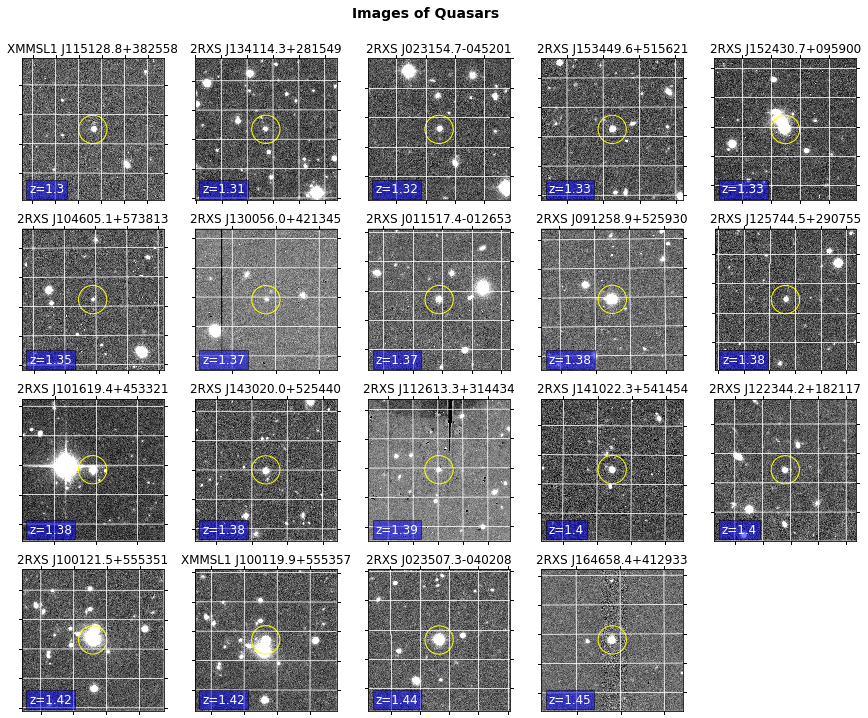

In [6]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LinearStretch, ZScaleInterval

np.seterr(divide='ignore', invalid='ignore')


def plot_image_list(data_list, geo=None):
    """ Plot the quasar image list"""

    # Build a layout if none is passed in
    if geo is None:
        geo = (len(data_list), 1)  # ncols, nrows

    # Dynamically create figsize based on layout
    fig = plt.figure(figsize=(geo[0] * 3, geo[1] * 3))
    fig.suptitle('Images of Quasars', fontsize=14, fontweight='bold', y=0.94)

    for idx, data in enumerate(data_list):
        ax = plt.subplot(geo[1], geo[0], idx + 1, projection=data['wcs'])

        # Draw yellow circle around quasar position
        ax.scatter(data['qso_ra'],
                   data['qso_dec'],
                   transform=ax.get_transform('icrs'),
                   s=800,
                   edgecolor='yellow',
                   facecolor='none')
        image_data_norm = ImageNormalize(data['image_data'],
                                         interval=ZScaleInterval(),
                                         stretch=LinearStretch())
        ax.imshow(data['image_data'], norm=image_data_norm, cmap='gray')
        ax.set_title(data['qso_name'])

        # Print redshift value
        ax.text(20,
                20,
                'z={:.3}'.format(data['qso_redshift']),
                fontsize=12,
                color='white',
                bbox={
                    'facecolor': 'blue',
                    'alpha': 0.5,
                    'pad': 3
                })
        ax.coords.grid(color='white', ls='solid')
        ra, dec = ax.coords['ra'], ax.coords['dec']
        ra.set_ticklabel_visible(False)
        dec.set_ticklabel_visible(False)
        ra.set_axislabel('')
        dec.set_axislabel('')


ncols = 5
nrows = math.ceil(len(cleaned_data_list) / ncols)
plot_image_list(cleaned_data_list, geo=(ncols, nrows))

Here is the final list of quasars. Luckily, we have caught one of the most well known quasars in our results! The [Twin Quasar](https://en.wikipedia.org/wiki/Twin_Quasar), with redshift `z=1.42`, labeled `2RXS J100121.5+555351` and `XMMSL1 J100119.9+555357` is actually one quasar that appears as two because of gravitational lensing. It is one of the first identified gravitationally lensed objects.

# References

Coffey,  D., Salvato, M., Merloni, A., Boller, Th., Nandra, K., Dwelly, T., Comparat, J., Schulze, A., Del Moro, A., and Schneider, D. P.,  “SDSS-IV/SPIDERS:  A catalogue of X-ray selected AGN properties - Spectral properties and black hole mass estimates for SPIDERS SDSS DR14 type 1 AGN,” _A&A_, vol. 625, p. A123, 2019.
  
Gwyn, S. D. J.,  “MegaPipe:  The MegaCam Image Stacking Pipeline at the Canadian Astronomical Data Centre,” _PASP_, vol. 120, p. 212, 2008.
